# Inference with Gibbs Sampling

The file `data.npy` contains data sampled from a mixture of $K=4$ Gaussians. The standard deviations of the Gaussians are known and are identical, $\sigma_k = \sigma = 0.5$. 

Reconstruct the unknown parameters and latent variables,

$$
p_k , \mu_k, Z_i
$$

where $Z_i$ represents the assignment of each point to one of the mixture components.
To perform the inference, use Gibbs sampling:

* Initialize randomly $p_k , \mu_k, Z_i$ , then compute
$$ N_k = \sum_i \chi(Z_i = k)
\\
m_k = \sum_i \chi(Z_i = k) \cdot x_k 
$$

* Perform Gibbs Sampling iterations
    - Sample $\mu_k$ from a Normal with mean and standard deviations:
     $$ 
     \mu_k' = \bigg( \dfrac{\mu_0}{\sigma_0^2} + \dfrac{m_k}{\sigma^2} \bigg) \cdot \dfrac{1}{\bigg( \dfrac{1}{\sigma_0^2} + \dfrac{N_k}{\sigma^2} \bigg)} \quad , \quad \sigma_k' = \bigg( \dfrac{1}{\sigma_0^2} + \dfrac{N_k}{\sigma^2} \bigg)^{-1/2} 
     $$. 
     
     Here $\mu_0 = 0$ and $\sigma_0 = 1000$ are the Gaussian prior parameters. Do this for all $k$.


    - Sample the $p_k$ from a Dirichelet with parameters $\gamma_k' = \gamma_k + N_k$. Here $\gamma_k = 1$ is the Dirichelet prior parameter. Do this for all $k$.


    - Sample the $Z_i$ from a categorical distribution, $Prob(Z_i = k) = \dfrac{p_k \cdot e^{- \frac{(x_i - \mu_k)^2}{2 \sigma^2}}}{\sum_k p_k \cdot e^{- \frac{(x_i - \mu_k)^2}{2 \sigma^2}}}$
  
  
    If $Z_i$ is updated, update $N_k, m_k$ accordingly.

---

## The Gibbs Sampling Algorithm

Gibbs sampling is a Markov chain Monte Carlo (MCMC) technique for estimating the joint distribution of a set of variables. It can be used to perform Bayesian inference, which is a way of making statistical inferences about unknown quantities based on the principles of probability theory.

The basic idea behind Gibbs sampling is to iteratively sample from the full conditional distributions of each variable, given the current values of all the other variables. This process generates a sequence of samples from the joint distribution, which can be used to approximate the posterior distribution of the variables.

To perform Gibbs sampling, you need to specify the full conditional distributions for each variable, which can be derived from the joint distribution and the conditional independence structure of the variables. You then initialize the values of the variables and iterate through the following steps:

* For each variable, sample a new value from its full conditional distribution given the current values of the other variables.
* Repeat this process until the samples converge to a stationary distribution, which is an approximate representation of the joint distribution.



Gibbs sampling can be an effective way to perform Bayesian inference, particularly when the joint distribution is complex and it is difficult to sample directly from it. It is also relatively simple to implement and can be used to efficiently estimate posterior distributions in large-scale models.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.special

import scipy.stats

In [2]:
#load the data from the file

dataset = np.loadtxt('data.txt')


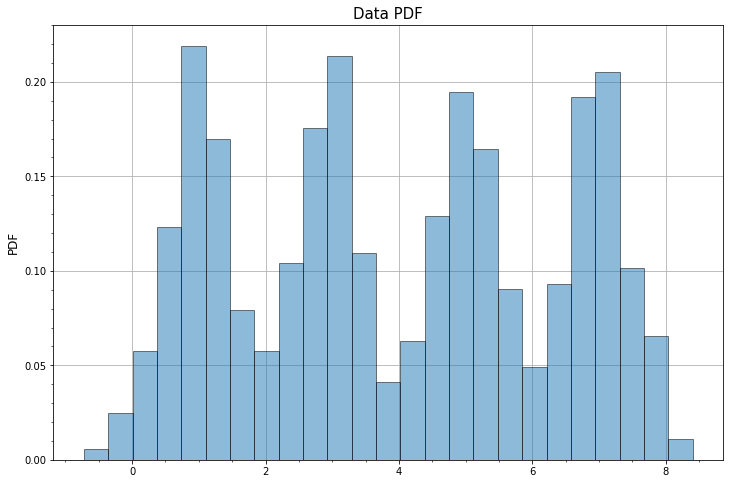

In [64]:
# Visualizing the data

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.hist(dataset, bins=np.arange(np.min(dataset) - 0.2 , np.max(dataset) + 0.2 , 0.365), 
        density=True, alpha = 0.5, edgecolor='black', zorder = 2)
ax.grid(zorder = 1)
ax.minorticks_on()
ax.set_title('Data PDF', fontsize = 15)
ax.set_ylabel('PDF', fontsize = 12)
plt.show()


In [4]:
K = 4

sigma = 0.5

In [5]:
# Define all the functions useful

def count_Nk(array):
    N_k_list = []
    
    for i in range(K):
        N_k_list.append(np.sum(array == i))
    
    return np.array(N_k_list)

def count_mk(array, x):
    m_k_list = np.zeros(K)
    
    for k in range(K):
        index = np.where(array == k)
        m_k_list[k] = np.sum(x[index])
    
    return np.array(m_k_list)

In [6]:
mu_0 = 0
sigma_0 = 1000

gamma_k = np.ones(K)

In [9]:
#sample mu_k
def sample_mu_k(Z_i):
    
    mu_k_prime = ( (mu_0/sigma_0**2) + ((count_mk(Z_i, dataset))/sigma**2) ) / ( (1/sigma_0**2) + ((count_Nk(Z_i))/sigma**2) )
    sigma_k_prime = ( (1/sigma_0**2) + ((count_Nk(Z_i))/(sigma**2)) )**(-1/2)
 
    sampled_mu_k = np.random.normal(mu_k_prime, sigma_k_prime)
        
    return sampled_mu_k
      
    
#sample p_k
def sample_p_k(Z_i):
    
    gamma_prime_k = gamma_k + count_Nk(Z_i)
        
    sampled_p_k = np.random.dirichlet(gamma_prime_k)
    
    return sampled_p_k
    
    
#sample Z_i
def sample_Z_i(p_k, mu_k, Z_i, dataset):
    
    sampled_Z_i = np.zeros(len(dataset))
    prob_Z_i_k = np.zeros((len(dataset), K))
    
    for i in range(len(dataset)):
            
        tmp = p_k * np.exp(- ((dataset[i] - mu_k)**2) / (2*sigma**2))
        
        prob_Z_i_k[i] = tmp / ( np.sum(tmp) )
            
        sampled_Z_i[i] = np.random.choice(np.arange(K), p = prob_Z_i_k[i])
            
               
    return sampled_Z_i
            

In [24]:
#Initialize the parameters

mu_k = np.random.uniform(np.min(dataset)+1, np.max(dataset)-1, K)

p_k = np.random.uniform(0, 1, K)
p_k = p_k / np.sum(p_k)

Z_i = np.random.randint(0, K, len(dataset))

# Gibbs Sampling

maxiter = 5000

# Lists to store the values
mu_list = []
pk_list = []
Z_i_list = []

mu_list.append(mu_k)
pk_list.append(p_k)
Z_i_list.append(Z_i)
    
for i in range(maxiter):
        
    #proposals
    proposal_mu = sample_mu_k(Z_i_list[i])
    proposal_pk = sample_p_k(Z_i_list[i])
    proposal_zi = sample_Z_i(pk_list[i], mu_list[i], Z_i_list[i], dataset)
    
  
    
    mu_list.append(proposal_mu)
    pk_list.append(proposal_pk)
    Z_i_list.append(proposal_zi)
   

In [26]:
from functools import reduce

mu_list = reduce(lambda x, y: np.vstack([x,y]), mu_list)
pk_list = reduce(lambda x, y: np.vstack([x,y]), pk_list)
Z_i_list = reduce(lambda x, y: np.vstack([x,y]), Z_i_list)


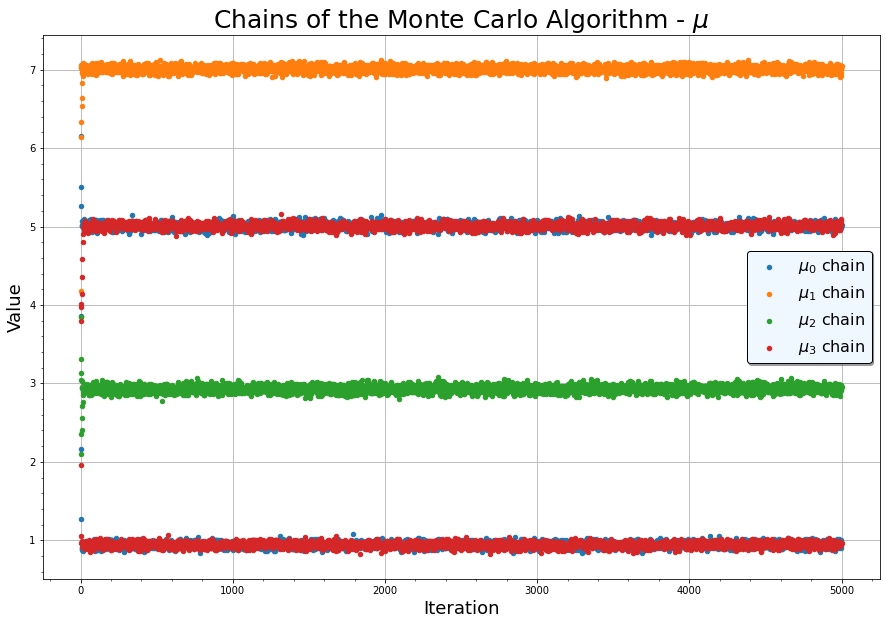

In [35]:
#Plotting the chains results

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

for i in range(K):
    ax.scatter(x = np.arange(len(mu_list)), y = mu_list[:,i], s=20, zorder = 2, label = f'$\mu_{i}$ chain')

ax.grid(zorder = 1)
ax.minorticks_on()

#ax.axvline(x = 30, color = 'black', linestyle = '--', zorder = 3, label = 'burn-in')
ax.set_title('Chains of the Monte Carlo Algorithm - $ \mu $', fontsize = 25)
ax.set_ylabel('Value', fontsize = 18)
ax.set_xlabel('Iteration', fontsize = 18)
ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', fontsize = 16)

plt.show()

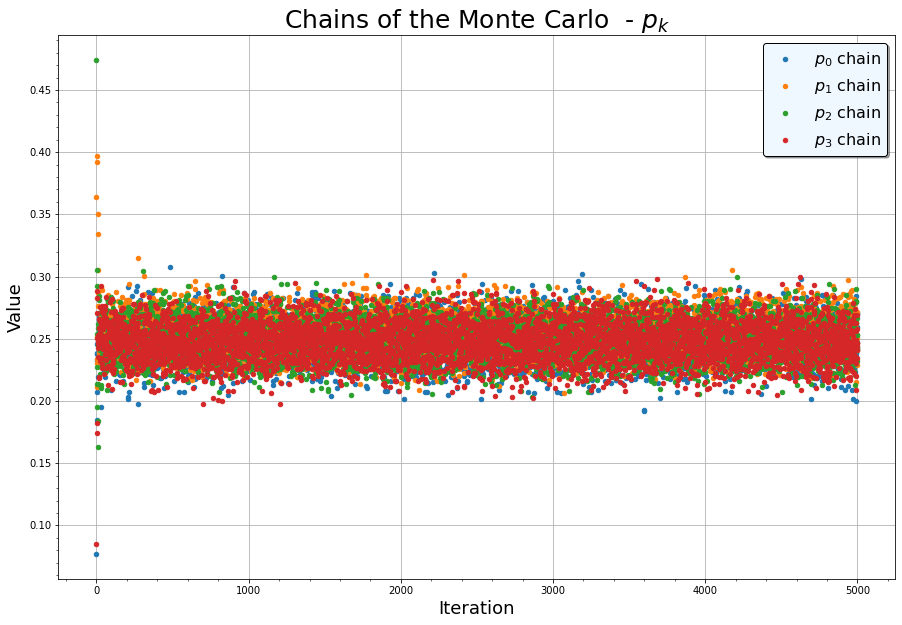

In [36]:
#Plotting the chains results

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

for i in range(K):
    ax.scatter(x = np.arange(len(pk_list)), y = pk_list[:,i], s=20, zorder = 2, label = f'$ p_{i}$ chain')


ax.grid(zorder = 1)
ax.minorticks_on()

#ax.axvline(x = 30, color = 'black', linestyle = '--', zorder = 3, label = 'burn-in')
ax.set_title('Chains of the Monte Carlo  - $p_k$', fontsize = 25)
ax.set_ylabel('Value', fontsize = 18)
ax.set_xlabel('Iteration', fontsize = 18)
ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', fontsize = 16)

plt.show()

In [42]:
print('The occurrence of each cluster is: \n')
print(count_Nk(Z_i_list[-1]))

The occurrence of each cluster is: 

[258 252 248 242]


In [43]:
print('The value of the mean of each cluster is: \n')
print(mu_list[-1])

The value of the mean of each cluster is: 

[5.01421362 7.05289912 2.95162141 0.96605655]


In [44]:
print('The value of the weight pk of each cluster is: \n')
print(pk_list[-1])

The value of the weight pk of each cluster is: 

[0.2430121  0.24092938 0.24690586 0.26915266]


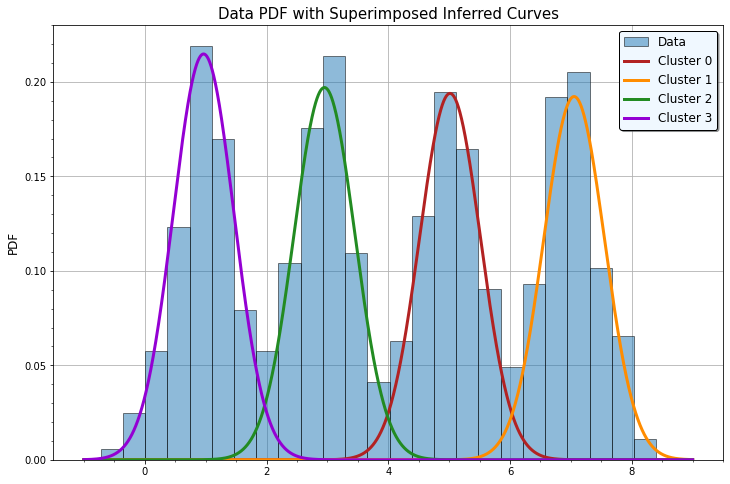

In [63]:
# Visualizing the data

x_axis = np.linspace(-1, 9, 10000)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.hist(dataset, bins=np.arange(np.min(dataset) - 0.2 , np.max(dataset) + 0.2 , 0.365), 
        density=True, alpha = 0.5, edgecolor='black', zorder = 2, label='Data')
ax.grid(zorder = 1)
ax.minorticks_on()
ax.set_title('Data PDF with Superimposed Inferred Curves', fontsize = 15)
ax.set_ylabel('PDF', fontsize = 12)

colors = ['firebrick', 'darkorange', 'forestgreen', 'darkviolet']
for i in range(K):
    ax.plot(x_axis, pk_list[-1][i]*scipy.stats.norm.pdf(x_axis, loc=mu_list[-1][i], scale=0.5), color = colors[i], 
            zorder = 3, label = f'Cluster {i}', linewidth = 3)
    
ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', fontsize = 12)
